In [1]:
# load modules
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, FloatType, StringType, ArrayType, DoubleType, BooleanType
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler 
from pyspark.mllib.linalg import Vectors
import pandas as pd
from functools import reduce 
import pyspark.sql.functions as f
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, when, isnan, count, udf, struct, date_format, coalesce, lit, round
from pyspark.sql.functions import broadcast


import os

In [2]:
# param init
'''spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("DS5110FinalProjectLoadData") \
    .config("spark.executor.memory", '20g') \
    .config('spark.executor.cores', '3') \
    .config('spark.executor.instances', '14') \
    .getOrCreate()
'''
spark = SparkSession.builder \
        .appName("housing") \
        .getOrCreate()

In [3]:
#Load data in
daysOM = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/daysOnMarket_All.parquet')
print(type(daysOM))
discount_share = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/discountShare_All.parquet')
print(type(discount_share))
medSP = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/medianSalesPrice_All.parquet')
print(type(medSP))
medAP_sale = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/medianAskingPrice_All.parquet')
print(type(medAP_sale))
medAP_rent = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/medianAskingRent_All.parquet')
print(type(medAP_rent))
price_cut_share = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/priceCutShare_All.parquet')
print(type(price_cut_share))
sales_vol = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/recordedSalesVolume_All.parquet')
print(type(sales_vol))
salesInventory = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/totalInventory_All.parquet')
print(type(salesInventory))
rentInventory = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/rentalInventory_All.parquet')
print(type(rentInventory))
sales_list_ratio = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/saleListRatio_All.parquet')
print(type(sales_list_ratio))
zips = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/zips_latlong.parquet')
print(type(zips))
bmap = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/borough_mapping.parquet')
print(type(bmap))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [4]:
#Create droppable columns since we only want data 2017 on
droppable = [col for col in daysOM.columns]
droppable = droppable[3:87]  #get droppable columns
#droppable

In [5]:
#Drop Columns
daysOM = daysOM.drop(*droppable)
#daysOM.printSchema()

discount_share = discount_share.drop(*droppable)
#discount_share.printSchema()

medSP = medSP.drop(*droppable)
#medSP.printSchema()

medAP_sale = medAP_sale.drop(*droppable)
#medAP_sale.printSchema()

medAP_rent = medAP_rent.drop(*droppable)
#medAP_rent.printSchema()

price_cut_share = price_cut_share.drop(*droppable)
#price_cut_share.printSchema()

sales_vol = sales_vol.drop(*droppable)
#sales_vol.printSchema()

salesInventory = salesInventory.drop(*droppable)
#salesInventory.printSchema()

rentInventory = rentInventory.drop(*droppable)
#rentInventory.printSchema()

sales_list_ratio = sales_list_ratio.drop(*droppable)
#sales_list_ratio.printSchema()

In [6]:
#Reshape dataframe
from pyspark.sql.functions import col, explode, array, struct, lit

def reshape(dataframe, column):
    # Filter data types and split into column names
    cols, dtypes = zip(*((col, dtype) for (col, dtype) in dataframe.dtypes if col not in column))
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"

    # Create and explode an array of (column_name, column_value)
    exp = explode(array([
      struct(lit(c).alias("date"), col(c).alias("value")) for c in cols
    ])).alias("exp")

    return dataframe.select(column + [exp]).select(column + ["exp.date", "exp.value"])

daysOM = reshape(daysOM.drop("areaType", "areaName"), ["Borough"])
discount_share = reshape(discount_share.drop("areaType", "areaName"), ["Borough"])
medSP = reshape(medSP.drop("areaType", "areaName"), ["Borough"])
medAP_sale = reshape(medAP_sale.drop("areaType", "areaName"), ["Borough"])
medAP_rent = reshape(medAP_rent.drop("areaType", "areaName"), ["Borough"])
price_cut_share = reshape(price_cut_share.drop("areaType", "areaName"), ["Borough"])
sales_vol = reshape(sales_vol.drop("areaType", "areaName"), ["Borough"])
salesInventory = reshape(salesInventory.drop("areaType", "areaName"), ["Borough"])
rentInventory = reshape(rentInventory.drop("areaType", "areaName"), ["Borough"])
sales_list_ratio = reshape(sales_list_ratio.drop("areaType", "areaName"), ["Borough"])

In [7]:
#Take a look at top 5
daysOM.show(5)
discount_share.show(5)
medSP.show(5)
medAP_sale.show(5)
medAP_rent.show(5)
price_cut_share.show(5)
sales_vol.show(5)
salesInventory.show(5)
rentInventory.show(5)
sales_list_ratio.show(5)

+---------+-------+-----+
|  Borough|   date|value|
+---------+-------+-----+
|Manhattan|2017-01|103.0|
|Manhattan|2017-02| 83.0|
|Manhattan|2017-03| 61.0|
|Manhattan|2017-04| 57.5|
|Manhattan|2017-05| 62.5|
+---------+-------+-----+
only showing top 5 rows

+---------+-------+-------------------+
|  Borough|   date|              value|
+---------+-------+-------------------+
|Manhattan|2017-01|              0.213|
|Manhattan|2017-02|0.20199999999999999|
|Manhattan|2017-03|              0.191|
|Manhattan|2017-04|              0.172|
|Manhattan|2017-05|              0.187|
+---------+-------+-------------------+
only showing top 5 rows

+---------+-------+---------+
|  Borough|   date|    value|
+---------+-------+---------+
|Manhattan|2017-01|1425275.0|
|Manhattan|2017-02|1479594.0|
|Manhattan|2017-03|1578287.0|
|Manhattan|2017-04|1700000.0|
|Manhattan|2017-05|1369818.5|
+---------+-------+---------+
only showing top 5 rows

+---------+-------+---------+
|  Borough|   date|    value|
+

In [8]:
#Show nan values
daysOM.filter(isnan(daysOM.value)).show()

+-------+-------+-----+
|Borough|   date|value|
+-------+-------+-----+
| Queens|2017-01|  NaN|
| Queens|2017-09|  NaN|
| Queens|2020-04|  NaN|
| Queens|2020-05|  NaN|
| Queens|2020-06|  NaN|
| Queens|2017-01|  NaN|
| Queens|2017-02|  NaN|
| Queens|2017-03|  NaN|
| Queens|2017-04|  NaN|
| Queens|2017-05|  NaN|
| Queens|2017-06|  NaN|
| Queens|2017-07|  NaN|
| Queens|2017-08|  NaN|
| Queens|2017-09|  NaN|
| Queens|2017-10|  NaN|
| Queens|2017-11|  NaN|
| Queens|2017-12|  NaN|
| Queens|2018-01|  NaN|
| Queens|2018-02|  NaN|
| Queens|2018-03|  NaN|
+-------+-------+-----+
only showing top 20 rows



In [9]:
#Null values
df_list = [daysOM, discount_share, medSP, medAP_sale, medAP_rent, price_cut_share, sales_vol, salesInventory, rentInventory , sales_list_ratio]
for i in df_list:
    i.select([count(when(isnan(c), c)).alias(c) for c in i.columns]).show()

+-------+----+-----+
|Borough|date|value|
+-------+----+-----+
|     53|   0| 7007|
+-------+----+-----+

+-------+----+-----+
|Borough|date|value|
+-------+----+-----+
|     53|   0| 3249|
+-------+----+-----+

+-------+----+-----+
|Borough|date|value|
+-------+----+-----+
|     53|   0| 3888|
+-------+----+-----+

+-------+----+-----+
|Borough|date|value|
+-------+----+-----+
|     53|   0| 2103|
+-------+----+-----+

+-------+----+-----+
|Borough|date|value|
+-------+----+-----+
|     53|   0| 2992|
+-------+----+-----+

+-------+----+-----+
|Borough|date|value|
+-------+----+-----+
|     53|   0| 3541|
+-------+----+-----+

+-------+----+-----+
|Borough|date|value|
+-------+----+-----+
|     53|   0|    0|
+-------+----+-----+

+-------+----+-----+
|Borough|date|value|
+-------+----+-----+
|     53|   0|    0|
+-------+----+-----+

+-------+----+-----+
|Borough|date|value|
+-------+----+-----+
|     53|   0|    0|
+-------+----+-----+

+-------+----+-----+
|Borough|date|value|
+---

In [10]:
#Calc average and fill na with
from pyspark.sql.functions import avg


#cols = list(set(daysOM.columns) - {'Borough', 'date'})
def fill_with_mean(df, exclude=set()): 
    stats = df.filter(isnan(df.value) != True).agg(*(avg(c).alias(c) for c in df.columns if c not in exclude))
    stats.show()
    return df.na.fill(stats.first().asDict(), subset=['value'])

daysOM = fill_with_mean(daysOM, ["Borough", "date"])
discount_share = fill_with_mean(discount_share, ["Borough", "date"])
medSP = fill_with_mean(medSP, ["Borough", "date"])
medAP_sale = fill_with_mean(medAP_sale, ["Borough", "date"])
medAP_rent = fill_with_mean(medAP_rent, ["Borough", "date"])
price_cut_share = fill_with_mean(price_cut_share, ["Borough", "date"])
sales_list_ratio = fill_with_mean(sales_list_ratio, ["Borough", "date"])

+-----------------+
|            value|
+-----------------+
|83.23186119873817|
+-----------------+

+-------------------+
|              value|
+-------------------+
|0.15720648723257416|
+-------------------+

+-----------------+
|            value|
+-----------------+
|790406.2586285195|
+-----------------+

+------------------+
|             value|
+------------------+
|1016392.2509831963|
+------------------+

+-----------------+
|            value|
+-----------------+
|2528.282591308984|
+-----------------+

+-------------------+
|              value|
+-------------------+
|0.10269567093341112|
+-------------------+

+------------------+
|             value|
+------------------+
|0.9596892778993433|
+------------------+



In [11]:
#Re-check nan values
daysOM.filter(isnan(daysOM.value)).show()

+-------+----+-----+
|Borough|date|value|
+-------+----+-----+
+-------+----+-----+



In [12]:
#Let's get averages to use for modeling
from pyspark.sql import functions as F
def average(dataframe):
    return dataframe.groupby(["date", "Borough"]).agg(F.avg("value")).orderBy("date")

In [13]:
#Apply function average on all dataframes - fill nan values to 0 (? idk what we want here)
daysOM = average(daysOM)
discount_share = average(discount_share)
medSP = average(medSP)
medAP_sale = average(medAP_sale)
medAP_rent = average(medAP_rent)
price_cut_share = average(price_cut_share)
sales_vol = average(sales_vol)
salesInventory = average(salesInventory)
rentInventory = average(rentInventory)
sales_list_ratio = average(sales_list_ratio)

In [14]:
#Rename value column (values are averages of borough per specific month)
daysOM=daysOM.withColumnRenamed("avg(value)", "avg_days_on_market")
discount_share = discount_share.withColumnRenamed("avg(value)", "avg_discount_share")
medSP=medSP.withColumnRenamed("avg(value)", "avg_median_sales_price")
medAP_sale=medAP_sale.withColumnRenamed("avg(value)", "avg_median_asking_sale")
medAP_rent=medAP_rent.withColumnRenamed("avg(value)", "avg_median_asking_rent")
price_cut_share = price_cut_share.withColumnRenamed("avg(value)", "avg_price_cut_share")
sales_vol = sales_vol.withColumnRenamed("avg(value)", "avg_sales_volume")
salesInventory=salesInventory.withColumnRenamed("avg(value)", "avg_sales_inventory")
rentInventory=rentInventory.withColumnRenamed("avg(value)", "avg_rent_inventory")
sales_list_ratio=sales_list_ratio.withColumnRenamed("avg(value)", "avg_sales_list_ratio")

In [15]:
#Combine dataframes
housing = daysOM.join(discount_share, ["date", "Borough"]).join(medSP, ["Borough", "date"]).join(medAP_sale, ["Borough", "date"]).join(medAP_rent, ["Borough", "date"]).join(price_cut_share, ["Borough", "date"]).join(sales_vol, ["Borough", "date"]).join(salesInventory, ["Borough", "date"]).join(rentInventory, ["Borough", "date"]).join(sales_list_ratio, ["Borough", "date"]).sort("date","Borough")

In [16]:
#Inspecting Data, the "nan" Borough is only NYC city - fix this 
from pyspark.sql.functions import regexp_replace
housing = housing.withColumn('Borough', regexp_replace('Borough', 'nan', 'NYC'))
#rename date
housing = housing.withColumnRenamed('date', 'month_year')

In [17]:
housing.show(5)

+-------------+----------+------------------+-------------------+----------------------+----------------------+----------------------+-------------------+------------------+-------------------+------------------+--------------------+
|      Borough|month_year|avg_days_on_market| avg_discount_share|avg_median_sales_price|avg_median_asking_sale|avg_median_asking_rent|avg_price_cut_share|  avg_sales_volume|avg_sales_inventory|avg_rent_inventory|avg_sales_list_ratio|
+-------------+----------+------------------+-------------------+----------------------+----------------------+----------------------+-------------------+------------------+-------------------+------------------+--------------------+
|        Bronx|   2017-01| 85.11642579414564|0.13011524868794833|     678922.9599095964|     816295.7564999047|     2078.865511832504|0.09341255405898169|15.023255813953488|  28.13953488372093| 41.16279069767442|  0.9595641952063507|
|     Brooklyn|   2017-01| 83.85466016633204|0.15861185268837438

### Get range of latitude/longitude for each borough in its' own column

In [14]:
#Change staten to staten island
#zips = zips.withColumn('borough', regexp_replace('borough', 'Staten', 'Staten Island'))

In [15]:
#Staten island is there
#zips.select('borough').distinct().show()

In [16]:
#Create List of all lat/long
#man_list = tuple(zips.where(col('borough')=='Manhattan').rdd.map(lambda x: (x.lat,x.long)).collect())
#queens_list = tuple(zips.where(col('borough')=='Queens').rdd.map(lambda x: (x.lat,x.long)).collect())
#brook_list = tuple(zips.where(col('borough')=='Brooklyn').rdd.map(lambda x: (x.lat,x.long)).collect())
#bronx_list = tuple(zips.where(col('borough')=='Bronx').rdd.map(lambda x: (x.lat,x.long)).collect())
#staten_list = tuple(zips.where(col('borough')=='Staten Island').rdd.map(lambda x: (x.lat,x.long)).collect())

In [17]:
#create dataframe
#schema = StructType([
#        StructField("Borough", StringType(), False),
#        StructField("range", ArrayType(ArrayType(DoubleType(), True), True), True)])
#data = [("Manhattan", man_list), ("Queens", queens_list), ("Brooklyn", brook_list), ("Bronx", bronx_list), ("Staten Island", staten_list)]
#rdd = spark.sparkContext.parallelize(data)#.map(lambda x: (x[0], to_float_list(x[1])))
#df = spark.createDataFrame(rdd, schema)

In [18]:
#df.show(5)

In [19]:
#Merge range of lat/long to housing data
#housing = housing.join(df, ["Borough"])

### Get citibike data and create month_year column. Merge in with bmap and housing

In [18]:
#citibike data
citi = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/gt2017_bikeweather.parquet')
citi = citi.withColumn('month_year', date_format(col('date'), "yyyy-MM"))
citi = citi.withColumn('start_lat_long', struct(col('startStationLatitude'), col('startStationLongitude')))
citi = citi.withColumn('end_lat_long', struct(col('endStationLatitude'), col('endStationLongitude')))
citi.show(2)

+----------+----+------------+--------------------+--------------+--------------------+--------------------+---------------------+------------+-----------------+------------------+-------------------+-------+----------+---------+------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+---+------+-----+--------+------------+----+---------+---------+---------+----------+--------------------+--------------------+
|      date|hour|tripduration|           starttime|startStationId|    startStationName|startStationLatitude|startStationLongitude|endStationId|   endStationName|endStationLatitude|endStationLongitude| bikeid|  usertype|birthyear|gender|  temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_main|dow|   day|month|time_bin|peak_commute|year|3h_precip|1h_precip|   precip|month_year|      start_lat_long|        end_lat_long|
+----------+----+------------+

In [19]:
#Inspect bmap
bmap.show(2)

+--------------+-------------------+--------------------+---------------------+--------+---------+
|startStationId|   startStationName|startStationLatitude|startStationLongitude|zipcodes|  Borough|
+--------------+-------------------+--------------------+---------------------+--------+---------+
|        3332.0|Degraw St & Hoyt St|         40.68199158|         -73.99079132|   11217| Brooklyn|
|        3545.0|Broadway & W 122 St|          40.8120575|         -73.96125793|   10027|Manhattan|
+--------------+-------------------+--------------------+---------------------+--------+---------+
only showing top 2 rows



In [20]:
#See if tuple of lat/lon in citi data exisit within range of borough zips
##citi.withColumn("Borough_start", coalesce(*[when(col(c).isin(man_list), "Manhattan") for c in citi.select("start_lat_long").collect()])
#).show()
#records = citi.where(reduce(lambda a, b: a|b, map(lambda val: col("start_lat_long").like(val.join(["%", "%"])), map(str, man_list))))
#check_man = f.udf(lambda x, y: (x, y) in man_list, BooleanType())
#citi.where(check_man(f.col("startStationLatitude"), f.col("startStationLongitude"))  == True)

In [21]:
#Join in bmap to get borough in citi
citi = citi.join(bmap, ["startStationId", "startStationName", "startStationLatitude", "startStationLongitude"])

In [22]:
#count - 49 mil rows
citi.count()

49394306

In [23]:
#Join in housing - final dataset - had to use broadcast hash join 
citi = citi.join(broadcast(housing), ["Borough", "month_year"])

In [24]:
#inspect final dataset
citi.show(2)

+---------+----------+--------------+--------------------+--------------------+---------------------+----------+----+------------+--------------------+------------+-----------------+------------------+-------------------+-------+----------+---------+------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+---+------+-----+--------+------------+----+---------+---------+---------+--------------------+--------------------+--------+------------------+-------------------+----------------------+----------------------+----------------------+-------------------+-----------------+-------------------+------------------+--------------------+
|  Borough|month_year|startStationId|    startStationName|startStationLatitude|startStationLongitude|      date|hour|tripduration|           starttime|endStationId|   endStationName|endStationLatitude|endStationLongitude| bikeid|  usertype|birthyear|gender|  temp|feels_like|temp_min|temp_m

In [25]:
#Save final dataset to parquet
citi.write.mode('overwrite').parquet('/project/ds5559/Summer2021_TeamBike/master_dataset.parquet')

### EDA of housing data

In [113]:
import seaborn as sb
import matplotlib.pyplot as plt

In [117]:
#Count of rows
housing.count()

318

In [120]:
#2021 data
twenty_one = housing.filter(col("date").startswith("2021"))
twenty_one_pd = twenty_one.toPandas()

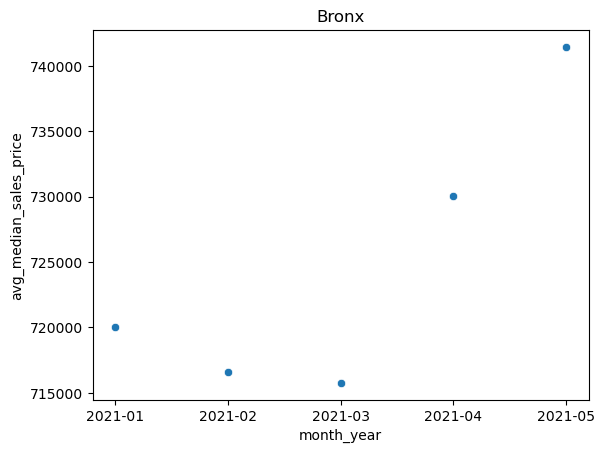

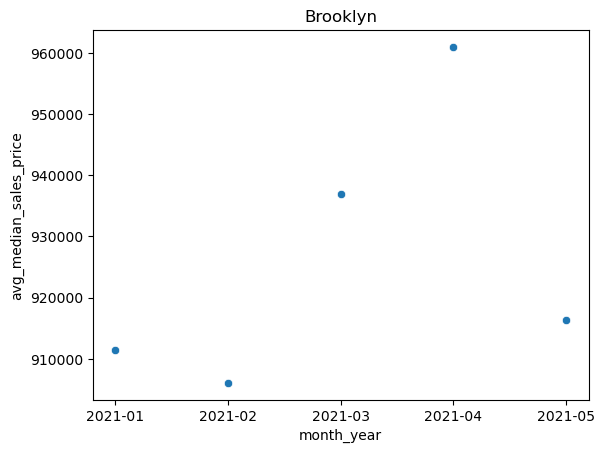

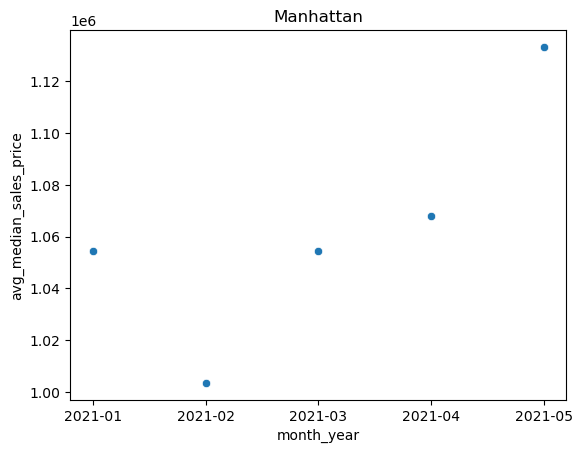

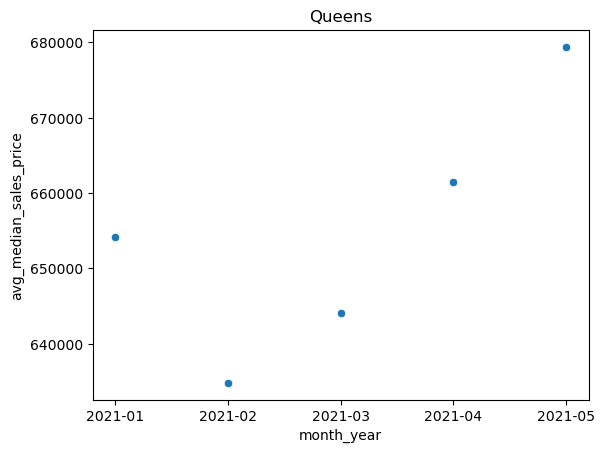

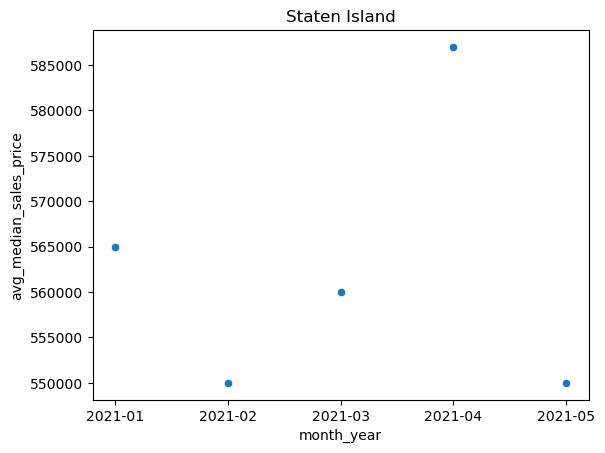

In [121]:
#Scatter for average median sales price for Bronx 2021
sb.scatterplot(data = twenty_one_pd.loc[twenty_one_pd['Borough'] == 'Bronx'], x = 'month_year', y = 'avg_median_sales_price').set_title("Bronx")
plt.show()
#Scatter for average median sales price for Brooklyn 2021
sb.scatterplot(data = twenty_one_pd.loc[twenty_one_pd['Borough'] == 'Brooklyn'], x = 'month_year', y = 'avg_median_sales_price').set_title("Brooklyn")
plt.show()
#Scatter for average median sales price for Manhattan 2021
sb.scatterplot(data = twenty_one_pd.loc[twenty_one_pd['Borough'] == 'Manhattan'], x = 'month_year', y = 'avg_median_sales_price').set_title("Manhattan")
plt.show()
#Scatter for average median sales price for Queens 2021
sb.scatterplot(data = twenty_one_pd.loc[twenty_one_pd['Borough'] == 'Queens'], x = 'month_year', y = 'avg_median_sales_price').set_title("Queens")
plt.show()
#Scatter for average median sales price for SI 2021
sb.scatterplot(data = twenty_one_pd.loc[twenty_one_pd['Borough'] == 'Staten Island'], x = 'month_year', y = 'avg_median_sales_price').set_title("Staten Island")
plt.show()

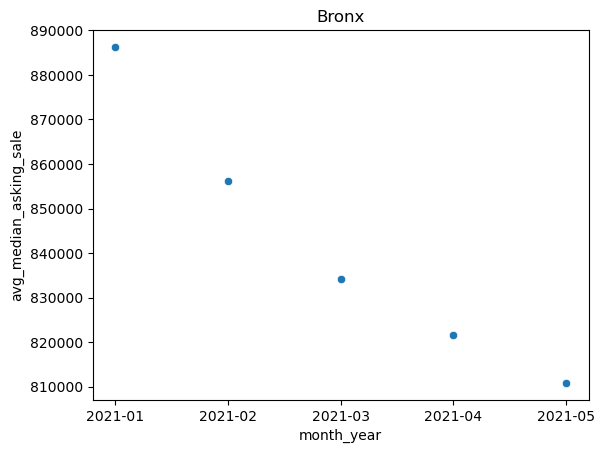

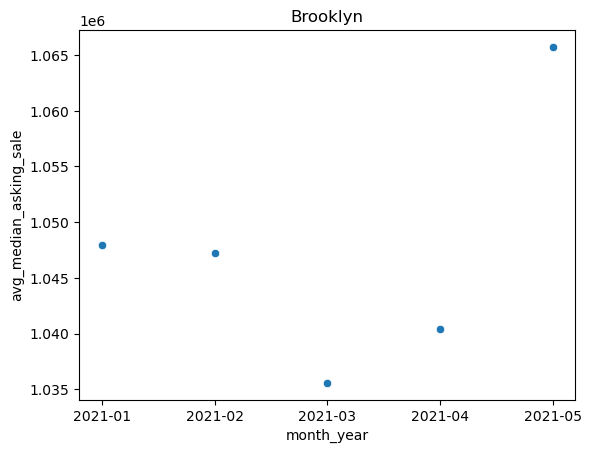

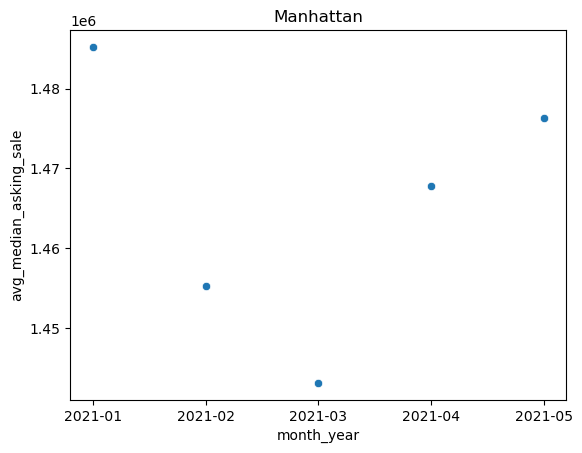

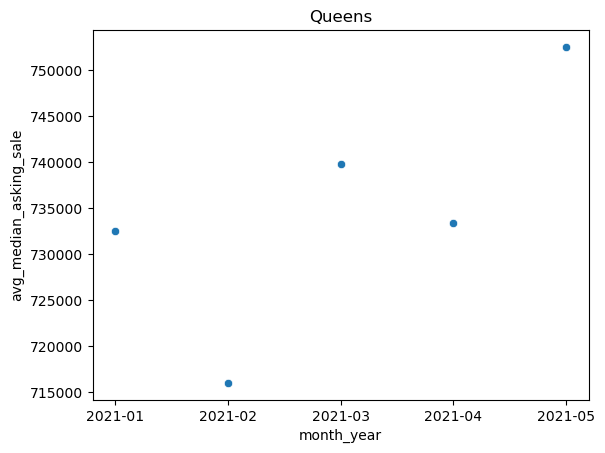

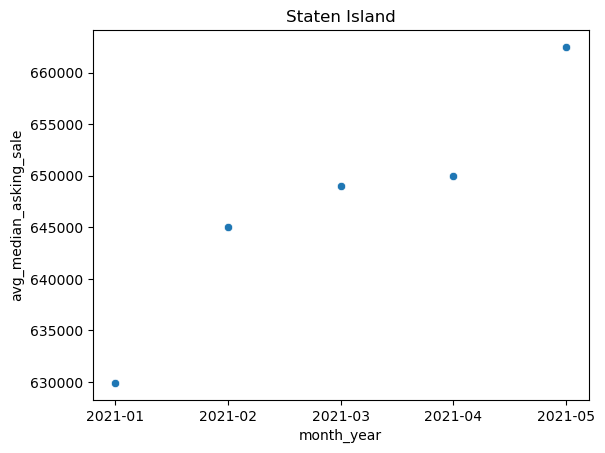

In [124]:
#Scatter for average median asking price for Bronx 2021
sb.scatterplot(data = twenty_one_pd.loc[twenty_one_pd['Borough'] == 'Bronx'], x = 'month_year', y = 'avg_median_asking_sale').set_title("Bronx")
plt.show()
#Scatter for average median asking price for Brooklyn 2021
sb.scatterplot(data = twenty_one_pd.loc[twenty_one_pd['Borough'] == 'Brooklyn'], x = 'month_year', y = 'avg_median_asking_sale').set_title("Brooklyn")
plt.show()
#Scatter for average median asking price for Manhattan 2021
sb.scatterplot(data = twenty_one_pd.loc[twenty_one_pd['Borough'] == 'Manhattan'], x = 'month_year', y = 'avg_median_asking_sale').set_title("Manhattan")
plt.show()
#Scatter for average median asking price for Queens 2021
sb.scatterplot(data = twenty_one_pd.loc[twenty_one_pd['Borough'] == 'Queens'], x = 'month_year', y = 'avg_median_asking_sale').set_title("Queens")
plt.show()
#Scatter for average median asking price for SI 2021
sb.scatterplot(data = twenty_one_pd.loc[twenty_one_pd['Borough'] == 'Staten Island'], x = 'month_year', y = 'avg_median_asking_sale').set_title("Staten Island")
plt.show()

In [122]:
#To Pandas for plotting
housing_pd = housing.toPandas()

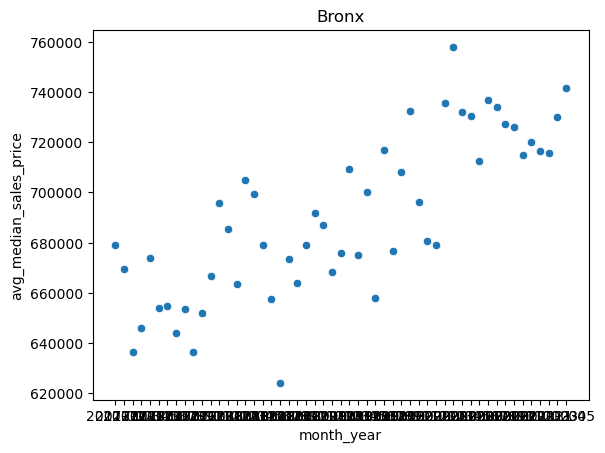

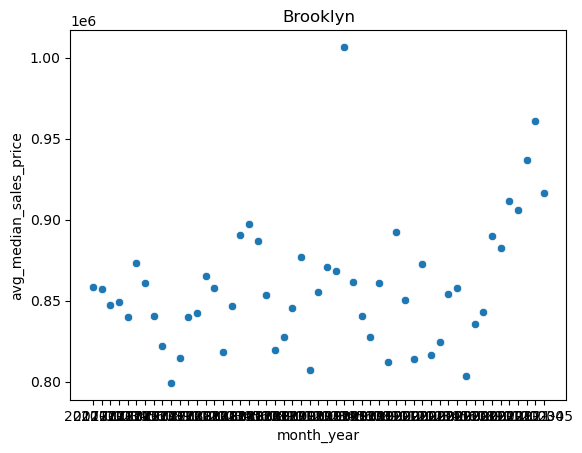

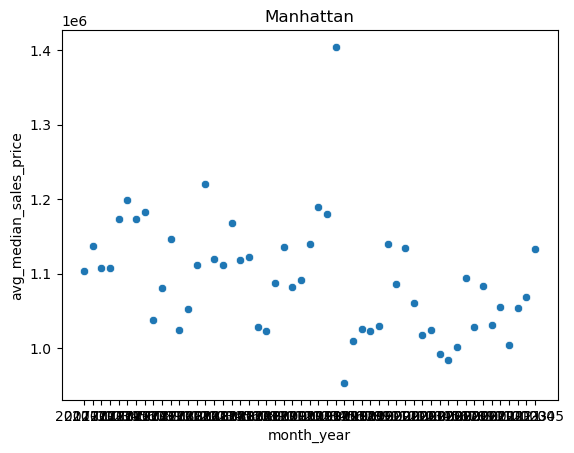

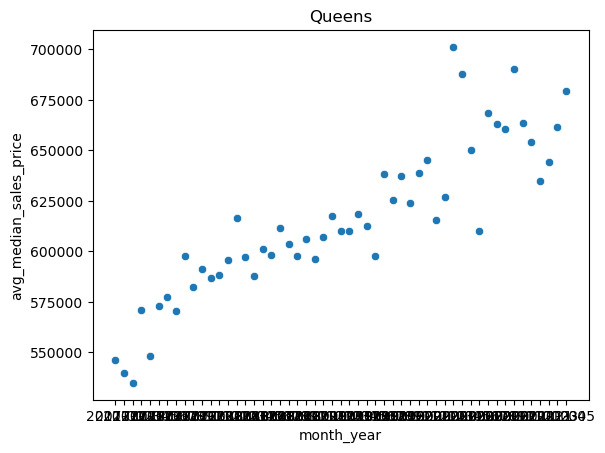

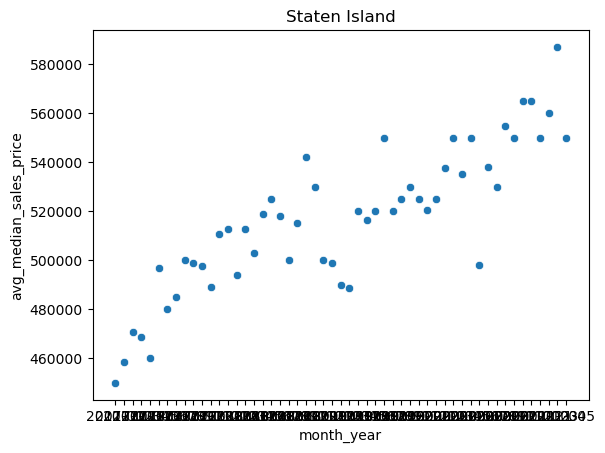

In [123]:
#Scatter for average days on market for Bronx from 2017-2021
sb.scatterplot(data = housing_pd.loc[housing_pd['Borough'] == 'Bronx'], x = 'month_year', y = 'avg_median_sales_price').set_title("Bronx")
plt.show()
#Scatter for average days on market for Brooklyn from 2017-2021
sb.scatterplot(data = housing_pd.loc[housing_pd['Borough'] == 'Brooklyn'], x = 'month_year', y = 'avg_median_sales_price').set_title("Brooklyn")
plt.show()
#Scatter for average days on market for Manhattan from 2017-2021
sb.scatterplot(data = housing_pd.loc[housing_pd['Borough'] == 'Manhattan'], x = 'month_year', y = 'avg_median_sales_price').set_title("Manhattan")
plt.show()
#Scatter for average days on market for Queens from 2017-2021
sb.scatterplot(data = housing_pd.loc[housing_pd['Borough'] == 'Queens'], x = 'month_year', y = 'avg_median_sales_price').set_title("Queens")
plt.show()
#Scatter for average days on market for Staten Island from 2017-2021
sb.scatterplot(data = housing_pd.loc[housing_pd['Borough'] == 'Staten Island'], x = 'month_year', y = 'avg_median_sales_price').set_title("Staten Island")
plt.show()

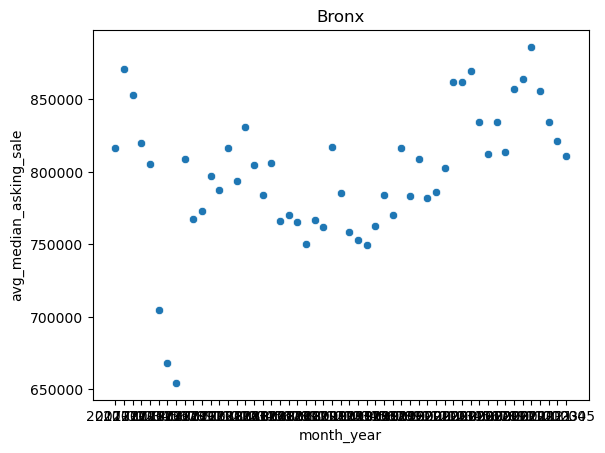

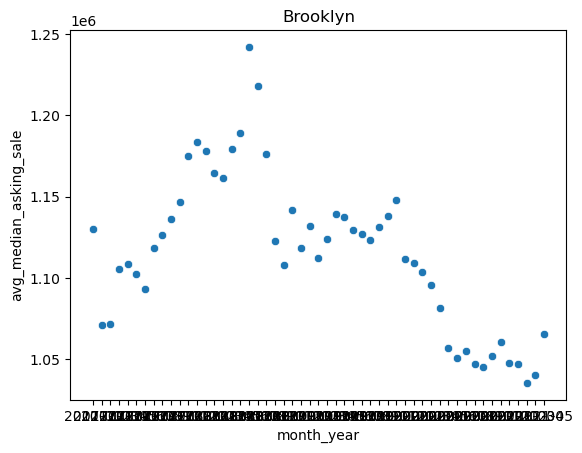

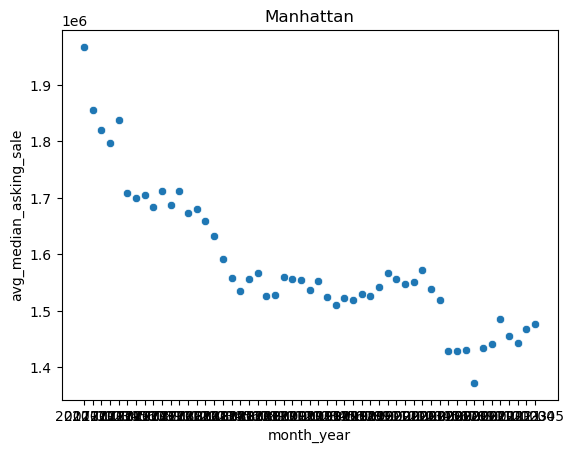

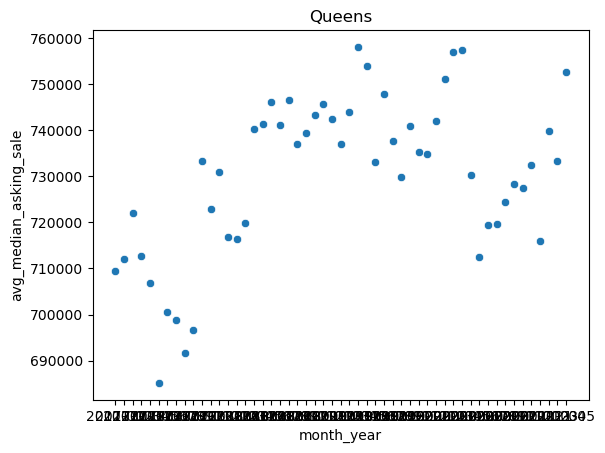

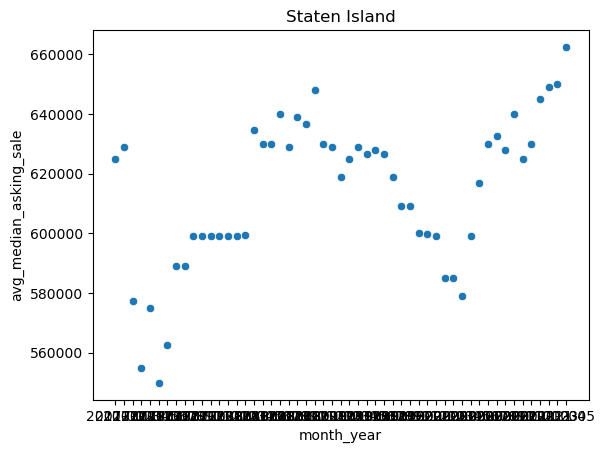

In [125]:
#Scatter for average median sales price for Bronx from 2017-2021
sb.scatterplot(data = housing_pd.loc[housing_pd['Borough'] == 'Bronx'], x = 'month_year', y = 'avg_median_asking_sale').set_title("Bronx")
plt.show()
#Scatter for average median sales price for Brooklyn from 2017-2021
sb.scatterplot(data = housing_pd.loc[housing_pd['Borough'] == 'Brooklyn'], x = 'month_year', y = 'avg_median_asking_sale').set_title("Brooklyn")
plt.show()
#Scatter for average median sales price for Manhattan from 2017-2021
sb.scatterplot(data = housing_pd.loc[housing_pd['Borough'] == 'Manhattan'], x = 'month_year', y = 'avg_median_asking_sale').set_title("Manhattan")
plt.show()
#Scatter for average median sales price for Queens from 2017-2021
sb.scatterplot(data = housing_pd.loc[housing_pd['Borough'] == 'Queens'], x = 'month_year', y = 'avg_median_asking_sale').set_title("Queens")
plt.show()
#Scatter for average median sales price for Staten Island from 2017-2021
sb.scatterplot(data = housing_pd.loc[housing_pd['Borough'] == 'Staten Island'], x = 'month_year', y = 'avg_median_asking_sale').set_title("Staten Island")
plt.show()

In [126]:
#Statistical summaries of potential predictors
[housing.select(col).describe().show() for col in housing.columns[2:12]]

+-------+------------------+
|summary|avg_days_on_market|
+-------+------------------+
|  count|               318|
|   mean| 81.97262267609472|
| stddev|14.119231133373503|
|    min|              40.0|
|    max|             140.0|
+-------+------------------+

+-------+-------------------+
|summary| avg_discount_share|
+-------+-------------------+
|  count|                318|
|   mean| 0.1557350503348311|
| stddev|0.04844761288131805|
|    min|              0.025|
|    max|0.33719507827539863|
+-------+-------------------+

+-------+----------------------+
|summary|avg_median_sales_price|
+-------+----------------------+
|  count|                   318|
|   mean|     738746.4281743508|
| stddev|    193748.55940379915|
|    min|              450000.0|
|    max|    1404366.2853924662|
+-------+----------------------+

+-------+----------------------+
|summary|avg_median_asking_sale|
+-------+----------------------+
|  count|                   318|
|   mean|     976723.2640138739|
| st

[None, None, None, None, None, None, None, None, None, None]